In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


In [ ]:
!git clone https://github.com/lukemelas/EfficientNet-PyTorch

fatal: destination path 'EfficientNet-PyTorch' already exists and is not an empty directory.


In [4]:
cd EfficientNet-PyTorch/

/content/drive/My Drive/Colab Notebooks/EfficientNet-PyTorch


In [ ]:
pip install -e .


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/EfficientNet-PyTorch
  Running setup.py develop for efficientnet-pytorch


Unzip

In [ ]:
!unzip -qq "/content/drive/My Drive/2022/datasets2.zip" -d "dest"

unzip:  cannot find or open /content/drive/My Drive/2022/datasets2.zip, /content/drive/My Drive/2022/datasets2.zip.zip or /content/drive/My Drive/2022/datasets2.zip.ZIP.


In [5]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=25)

224


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [6]:
## data load
batch_size  = 128
random_seed = 123
random.seed(random_seed)
torch.manual_seed(random_seed)

In [7]:
## make dataset
from torchvision import transforms, datasets
data_path = '/content/drive/MyDrive/Colab Notebooks/dataset'
dog_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))

In [8]:
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
tmp_idx, test_idx = train_test_split(list(range(len(dog_dataset))), test_size=0.3, random_state=random_seed)
datasets = {}
tmp_dataset = Subset(dog_dataset, tmp_idx) # test 3
datasets['test']  = Subset(dog_dataset, test_idx)

train_idx, val_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.2, random_state=random_seed)
datasets['train'] = Subset(tmp_dataset, train_idx) # test 0.7 * 0.
datasets['valid']  = Subset(tmp_dataset, val_idx) # valid 0.7 * 0.2

## data loader
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 128,  tvt : 15 / 4 / 8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


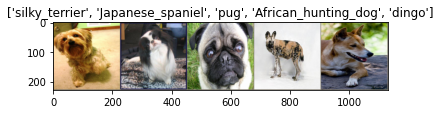

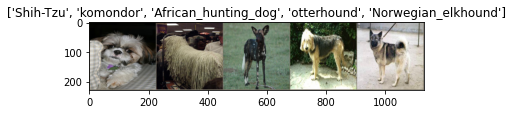

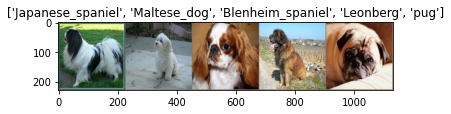

In [9]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    "0": "African_hunting_dog",      
    "1": "Blenheim_spaniel",                  
    "2": "Bonston_bull",                  
    "3": "Chihuahua",  
    "4": "EntleBucher",         
    "5": "Japanese_spaniel",              
    "6": "Leonberg",
    "7": "Maltese_dog",
    "8": "Norwegian_elkhound",
    "9": "Pomeranian",
    "10": "Shih-Tzu",
    "11": "Siberian_husky",
    "12": "Welsh_springer_spaniel",
    "13": "Yorkshire_terrier",
    "14": "basenji",
    "15": "beagle",
    "16": "black-and-tan_coonhound",
    "17": "clumber",
    "18": "dingo",
    "19": "keeshond",
    "20": "komondor",
    "21": "otterhound",
    "22": "pug",
    "23": "silky_terrier",
    "24": "standard_schnauzer",
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch image show
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch image show
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch image show
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

Train code

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'dogs_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

Settings

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.01,
                         momentum=0.9,
                         weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=10, eta_min=0.001)

Training

In [16]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 3.06 Acc: 21.4
valid Loss: 2.60 Acc: 74.7
==> best model saved - 0 / 74.7
Epoch 1/29
----------
train Loss: 2.21 Acc: 75.8
valid Loss: 1.32 Acc: 85.5
==> best model saved - 1 / 85.5
Epoch 2/29
----------
train Loss: 1.24 Acc: 87.3
valid Loss: 0.52 Acc: 89.6
==> best model saved - 2 / 89.6
Epoch 3/29
----------
train Loss: 0.68 Acc: 91.8
valid Loss: 0.33 Acc: 91.6
==> best model saved - 3 / 91.6
Epoch 4/29
----------
train Loss: 0.46 Acc: 93.4
valid Loss: 0.29 Acc: 92.1
==> best model saved - 4 / 92.1
Epoch 5/29
----------
train Loss: 0.34 Acc: 95.8
valid Loss: 0.26 Acc: 93.0
==> best model saved - 5 / 93.0
Epoch 6/29
----------
train Loss: 0.29 Acc: 95.8
valid Loss: 0.25 Acc: 93.2
==> best model saved - 6 / 93.2
Epoch 7/29
----------
train Loss: 0.25 Acc: 96.6
valid Loss: 0.25 Acc: 92.5
Epoch 8/29
----------
train Loss: 0.24 Acc: 96.5
valid Loss: 0.25 Acc: 92.7
Epoch 9/29
----------
train Loss: 0.23 Acc: 97.2
valid Loss: 0.24 Acc: 93.0
Epoch 10/29
----

Print graph

best model : 22 - 94 / 0.2


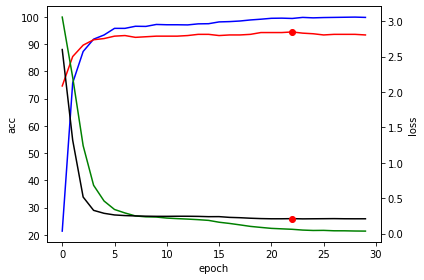

In [17]:
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

Test

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test done : loss/acc : 0.21 / 93.2


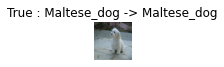

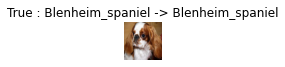

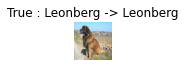

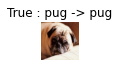

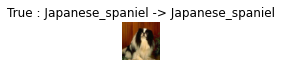

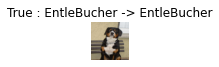

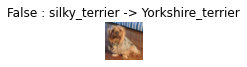

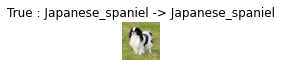

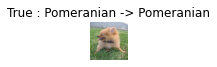

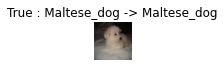

In [18]:
def test_and_visualize_model(model, phase = 'test', num_images=10):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # example image plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # example image plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])          
            if i == 0 : break
    model.train(mode=was_training);  # train mode

## TEST!
test_and_visualize_model(model, phase = 'test')